In [2]:
import os
import pandas as pd
import numpy as np


main_publisher = 'OYC'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_chapters_embeddings = pd.read_csv(path + 'embeddings_chapters.csv', delimiter = '|', index_col=0)
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_concepts_embeddings = pd.read_csv(path + 'embeddings_concepts_bis.csv', delimiter = '|', index_col=0)
df_classes = pd.read_csv(path + 'classes.csv', delimiter = '|')
df_classes_embeddings = pd.read_csv(path + 'embeddings_classes_bis.csv', delimiter = '|', index_col=0)
df_precedences_episodes = pd.read_csv(path + 'precedences_episodes.csv', delimiter = '|')
df_precedences_series = pd.read_csv(path + 'precedences_series.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

df_classes = df_classes.dropna()
print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_classes.isna().sum().sum():04d} Nan values in classes.')
print(f'{df_precedences_episodes.isna().sum().sum():04d} Nan values in episdes precedences.')
print(f'{df_precedences_series.isna().sum().sum():04d} Nan values in series precedences.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0000 Nan values in classes.
0000 Nan values in episdes precedences.
0000 Nan values in series precedences.


In [3]:
from utils import *

unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')
unique_class_id =  id_mapper(df_classes['Class'], 'Class')

In [4]:
oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_pr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')

oer_before_oer_ep_subject = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_ep_object = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')
oer_before_oer_sr_subject = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_sr_object = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

concept_belongs_class_subject = edge_construction(df1 = df_classes, df2 = unique_concept_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Concept', right_on = 'Concept')
concept_belongs_class_object = edge_construction(df1 = df_classes, df2 = unique_class_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Class', right_on = 'Class')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0).long()
oer_covers_concept_rev = torch.stack([oer_covers_concept_object, oer_covers_concept_subject], dim = 0).long()
oer_before_oer_ep = torch.stack([oer_before_oer_ep_subject, oer_before_oer_ep_object], dim = 0).long()
oer_before_oer_sr = torch.stack([oer_before_oer_sr_subject, oer_before_oer_sr_object], dim = 0).long()
concept_belongs_class = torch.stack([concept_belongs_class_subject, concept_belongs_class_object], dim = 0).long()
concept_belongs_class_rev = torch.stack([concept_belongs_class_object, concept_belongs_class_subject], dim = 0).long()
print(oer_covers_concept.shape)
print(oer_covers_concept_rev.shape)
print(oer_before_oer_ep.shape)
print(oer_before_oer_sr.shape)
print(concept_belongs_class.shape)
print(concept_belongs_class_rev.shape)

torch.Size([2, 16786])
torch.Size([2, 16786])
torch.Size([2, 2097])
torch.Size([2, 423])
torch.Size([2, 58295])
torch.Size([2, 58295])


In [5]:
chapters_embeddings_tmp = {}
concepts_embeddings_tmp = {} 
classes_embeddings_tmp = {}

chapters_r = range(len(df_chapters['Cid'].unique()))
concepts_c = range(len(df_concepts['Concept'].unique()))
classes_c = range(len(df_classes['Class'].unique()))

chapters_embeddings = np.zeros(shape=(len(chapters_r), 768))
concepts_embeddings = np.zeros(shape=(len(concepts_c), 768))
classes_embeddings = np.zeros(shape=(len(classes_c), 768))


i = 0
for r in chapters_r:
    chapters_embeddings_tmp[r] = list(filter(None, df_chapters_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    chapters_embeddings_tmp[r] = [float(f) for f in chapters_embeddings_tmp[r]]
    for a in range(len(chapters_embeddings_tmp[r])):
            chapters_embeddings[i][a] = chapters_embeddings_tmp[r][a]
    i += 1

i = 0
for r in concepts_c:
    concepts_embeddings_tmp[r] = list(filter(None, df_concepts_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    concepts_embeddings_tmp[r] = [float(f) for f in concepts_embeddings_tmp[r]]
    for a in range(len(concepts_embeddings_tmp[r])):
            concepts_embeddings[i][a] = concepts_embeddings_tmp[r][a]
    i += 1   

i = 0
for r in classes_c:
    classes_embeddings_tmp[r] = list(filter(None, df_classes_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    classes_embeddings_tmp[r] = [float(f) for f in classes_embeddings_tmp[r]]
    for a in range(len(classes_embeddings_tmp[r])):
            classes_embeddings[i][a] = classes_embeddings_tmp[r][a]
    i += 1

chapters_embeddings = torch.from_numpy(chapters_embeddings).to(torch.float32)
concepts_embeddings = torch.from_numpy(concepts_embeddings).to(torch.float32)
classes_embeddings = torch.from_numpy(classes_embeddings).to(torch.float32)

In [6]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['Class'].node_id = torch.tensor(unique_class_id['mappedID'].values)
data['Class'].x = classes_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep
data['Concept', 'belongs', 'Class'].edge_index = concept_belongs_class
data['Class', 'rev_belongs', 'Concept'].edge_index = concept_belongs_class_rev

#data = T.ToUndirected()(data)
data.validate()
print(data)

/home/abazouzi/Documents/Code/PrerequisiteLearning/clara-datasets/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 2097])
HeteroData(
  OER={
    node_id=[2550],
    x=[2550, 768]
  },
  Concept={
    node_id=[6007],
    x=[6007, 768]
  },
  Class={
    node_id=[292],
    x=[292, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 16786],
    edge_attr=[16830]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 16786] },
  (OER, before_sr, OER)={ edge_index=[2, 423] },
  (OER, before_ep, OER)={ edge_index=[2, 2097] },
  (Concept, belongs, Class)={ edge_index=[2, 58295] },
  (Class, rev_belongs, Concept)={ edge_index=[2, 58295] }
)


In [7]:
import random

def seed_everything(seed=0):                                                  
       random.seed(seed)                                                            
       torch.manual_seed(seed)                                                      
       torch.cuda.manual_seed_all(seed)                                             
       np.random.seed(seed)                                                         
       os.environ['PYTHONHASHSEED'] = str(seed)                                     
       torch.backends.cudnn.deterministic = True                                    
       torch.backends.cudnn.benchmark = False



In [8]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.1
    num_test = 0.1
seed_everything()
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.0,
    neg_sampling_ratio = 0.8,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')
print(train_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(train_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])

610	 Edges for training
75	 Edges for validation
75	 Edges for testing
tensor([1692, 1554, 2541, 1480,  422])
tensor([2187,  412, 1881, 1991,  541])
tensor([2529,  769, 2363, 1027, 1958])
tensor([1693, 1555, 2542, 1481,  423])
tensor([2188,  413, 1882, 1992,  542])
tensor([2530,  770, 2364, 1028, 1959])


In [9]:
seed_everything()
cross_val_data = {}
cross_val_data["OER", "before_sr", "OER"] = {}
print(len(train_data["OER", "before_sr", "OER"].edge_label_index[0]) + 
      len(val_data["OER", "before_sr", "OER"].edge_label_index[0]) +
      len(test_data["OER", "before_sr", "OER"].edge_label_index[0]))

cross_val_data["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label, 
     val_data["OER", "before_sr", "OER"].edge_label,
     test_data["OER", "before_sr", "OER"].edge_label], 
    dim = 0).long()
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label_index, 
     val_data["OER", "before_sr", "OER"].edge_label_index,
     test_data["OER", "before_sr", "OER"].edge_label_index], 
    dim = 1).long()
cross_val_data["OER", "before_sr", "OER"]["edge_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_index, 
     val_data["OER", "before_sr", "OER"].edge_index,
     test_data["OER", "before_sr", "OER"].edge_index],
    dim = 1).long()
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_index"][0]))

760
760
760
1059


In [10]:
seed_everything()
num_samples = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
shuffled_index = np.arange(num_samples)
np.random.shuffle(shuffled_index)
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][shuffled_index]
print(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0])
print(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1])
print(cross_val_data["OER", "before_sr", "OER"]["edge_label"])

tensor([   3, 1603,  545, 1779, 1460, 1287,  331, 1212,  402,  587, 1371, 1932,
        1559, 1114,  876, 2440,   48, 2233, 1376, 1706, 1384,  795, 1875, 1043,
         519,  824, 1455, 2348, 1907, 1973,  749, 1662, 1791, 1159, 1280, 1996,
        1221,  782, 1430,  515, 1985,   53, 2321, 1096, 2333, 2301, 2225,  264,
        1864, 1287, 1554, 1070,  374, 1018, 1682, 1024, 2303, 1333, 2010, 2275,
        1894, 1072,  443, 1044, 2083, 1814,  264,  957,  591,  916,  933,  734,
         541, 1119, 1176,  200, 1040,  306,  853, 2194, 2232, 1671, 2073, 2329,
         525, 1914,  907,  960, 1322, 1303, 1759, 1284,  185, 1363, 2141, 2343,
         634, 1482,  129,  787, 2260, 1225, 1933, 1353,  743, 2541, 2403, 1935,
         301,  852, 2250, 1768,  518, 2179,  985, 2004, 2325, 2161, 1246, 1067,
        1027, 2336,  434,  407,  662,  169, 2092, 1686, 1502, 2360, 2546,  656,
         730, 1527,  502,  627,  799, 2212, 2523,  678, 1050,   21, 1040, 1367,
         428, 2417,  204, 1323,  148, 10

In [11]:
cv = 5
chunk_size = int(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]) / cv)
cross_val_chunks = []
for n in range(cv):
    cross_val_chunk = {}
    cross_val_chunk["OER", "before_sr", "OER"] = {}
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = {}
    begin = n * chunk_size
    if n == cv - 1:
        end = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
    else :
        end = (n+1) * chunk_size
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][begin : end]
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][begin : end])
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][begin : end])
    cross_val_chunks.append(cross_val_chunk)

In [12]:
cross_val_data_train = []
cross_val_data_test = []
for n in range(cv) :
    cross_val_data_train_chunk = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label"], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label"]
     ], 
    dim = 0).long()
    cross_val_data_test_chunk = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label"]

    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0]
     ], 
    dim = 0).long())
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1]
     ], 
    dim = 0).long())
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][0])
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][1])
    
    cross_val_data_train.append(cross_val_data_train_chunk)
    cross_val_data_test.append(cross_val_data_test_chunk)

len(cross_val_data_train)

5

In [13]:
def train(model, train_data, epochs, lr, verbose = False):
    total_loss = 0
    loss_values = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    duration = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        ground_truth = train_data["OER", "before_sr", "OER"].edge_label
        assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
        loss = F.binary_cross_entropy_with_logits(pred.float(), ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        loss_values.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")
    duration = time.time() - duration
    
    return {
        'Loss_values' : loss_values,
        'Loss' : total_loss,
        'Duration' : duration,
        'Model' : model
    }
def predict(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    #auc_score = roc_auc_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1
    }

In [14]:
hidden_channels_selected = 16
entity_features = 768
num_layers_selected = 6
epochs_selected = 300 #300 the best
learning_rates_selected = 0.01

selected_params = [{
    'epochs': epochs_selected, 
    'hidden_channels': hidden_channels_selected, 
    'num_layers': num_layers_selected, #8 is too much => generated NaN values in node attributes
    'lr': learning_rates_selected, 
    'entity_features': entity_features
}]

In [15]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATConv, Linear, SimpleConv, GATv2Conv, MLP
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os

class ModelSAGE(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'belongs', 'Class') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Class', 'rev_belongs', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [18]:
df_ModelSAGE = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(1) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelSAGE(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelSAGE = pd.concat([df_ModelSAGE, pd.DataFrame([results])], ignore_index = True)
df_ModelSAGE.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,36.399593,0.865169,0.914474,0.912509,0.913633,3.25819,36.395284


In [17]:
print(round(df_ModelSAGE["Test Accuracy"].values.min(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.mean(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.max(), 2))

0.91
0.93
0.96


In [43]:
def predict_labels(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1,
        'preds' : preds_labels,
        'truths': ground_truths
    }
results_labels = predict_labels(model, test_data)
print(results_labels['preds'][:5])
print(results_labels['truths'][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label[:5])

[0 0 0 1 1]
tensor([0, 0, 0, 1, 1])
tensor([   3, 1603,  545, 1779, 1460])
tensor([1940, 1433,  578, 1780, 1461])
tensor([0, 0, 0, 1, 1])


In [63]:
def get_concepts(c_id, df_concepts):
    return df_concepts[df_concepts['OER'] == c_id]['Concept'].values

def remap_oer_id(c_id, unique_oer_id):
    return unique_oer_id[unique_oer_id['mappedID'] == c_id]['OER'].values[0]

c_id = 2400
true_c_id = remap_oer_id(c_id, unique_oer_id)
print(c_id, true_c_id)
print(get_concepts(true_c_id, df_concepts))

2400 2400
['Evolutionary_psychology' 'Psychology' 'Spock' 'Steven_Pinker'
 'William_James']


In [74]:
def jaccard_index(a, b):
    '''
    Calculates the Jaccard index between two sets or lists
    Input :
        a,b : input sets or lists
    Output :
        jaccard index
    '''
    #if(type(a) == list):
    a = set(a)
    #if(type(b) == list):
    b = set(b)
    return len(a & b) / len(a | b)

In [76]:
size = len(results_labels['truths'])
positive_list = []
negative_list = []
for i in range(size):
    oer_one = test_data["OER", "before_sr", "OER"].edge_label_index[0][i].item()
    oer_two = test_data["OER", "before_sr", "OER"].edge_label_index[1][i].item()
    oer_one_concepts = get_concepts(remap_oer_id(oer_one, unique_oer_id), df_concepts)
    oer_two_concepts = get_concepts(remap_oer_id(oer_two, unique_oer_id), df_concepts)
    jaccard = jaccard_index(oer_one_concepts, oer_two_concepts)
    if test_data["OER", "before_sr", "OER"].edge_label[i] == 0:
        negative_list.append(jaccard)
    else:
        positive_list.append(jaccard)

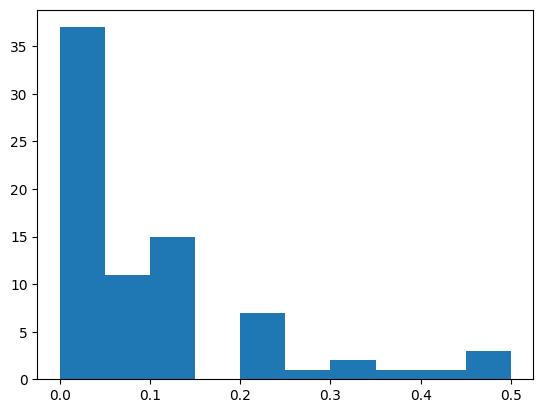

In [84]:
import matplotlib.pyplot as plt

plt.hist(positive_list)
plt.show()

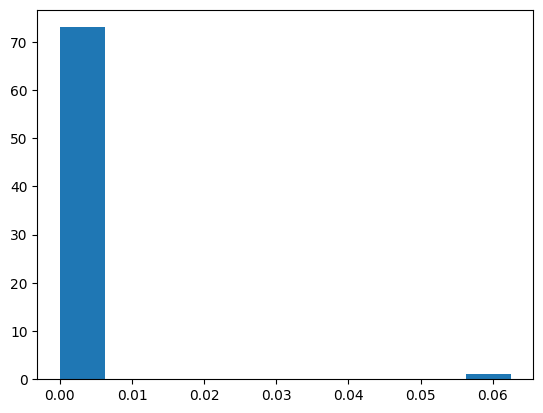

In [85]:
plt.hist(negative_list)
plt.show()